# **Political Polarization**
---

### **Introduction**
---

With the rise of social media and the increase of information on the internet, over the last few decades, the gap between America's two main political parties, Democrats and Republicans, has grown wider. There have been many good studies that have researched the trend of the growing polarization between the two parties and the ever shrinking middle ground. For this project I wanted to look at twitter data from two prominent congressmen from each party. With politics at it's most divided, I expect it to be relativley easy to find differences in the language used by each party. The two congressmen I will be using is Alexandria Ocasio-Cortez, a democrat representing New York's 14th congressional district. The other is Senator Ted Cruz from Texas who is a republican. The goal of this project is to see if I can build a model that can accurately predict which congressmen tweeted what. Politics can be a stressful topic for some, especially after this year, so the tone of this project is meant to be fun and light-hearted.

### **Data**
---

After searching on the web for the best way to scrape twitter accounts, I found tool that could scrape twitter data through the command line. With a bit more searching I found a python wrapper library for that tool. I created my own function using this library to fine tune the tool and get exaclty what I wanted. The data is from the twitter accounts 'AOC' and 'SenTedCruz' consisting of all thier tweets from Janurary 1, 2020 - December 1, 2020. Below are the links to the sources that helped me gather the data  
*Sources*   
https://github.com/MartinBeckUT/TwitterScraper/blob/master/snscrape/python-wrapper/snscrape-python-wrapper.ipynb  
https://medium.com/better-programming/how-to-scrape-tweets-with-snscrape-90124ed006af

In [1]:
# Run the pip install command below to install the library
# !pip install git+https://github.com/JustAnotherArchivist/snscrape.git

In [2]:
import pandas as pd
import numpy as np
import re
import snscrape.modules.twitter as sntwitter
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.style as style

In [3]:
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

In [4]:
def scrape_twitter_account(account, start_date, end_date, num_tweets):
    temp_str = 'from:' + account + ' since:' + start_date + ' until:' + end_date
    temp_list = []
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(temp_str).get_items()):
        if i > num_tweets:
            break
        temp_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
    return temp_list

In [5]:
#setting the number of tweets I want to return
n_tweets = 3000

#setting what twitter accounts I want to scrape
twitter_accounts = ['AOC', 'SenTedCruz']

#setting time period of tweets to get an accurate comparison
start_date = '2020-01-01'
end_date = '2020-12-01'

aoc_tweets = scrape_twitter_account(twitter_accounts[0], start_date, end_date, n_tweets)
cruz_tweets = scrape_twitter_account(twitter_accounts[1], start_date, end_date, n_tweets)

Once I collected the data, the next step was to clean the tweets. One of the first things I had to do was to remove twitter username handles from the tweets. I created my own function to do this that worked, but I found a package from the nltk library that could strip twitter usernames for me. (Lucky me!) I also made all the text lower case and cleaned it of non-alphanumeric characters. Finally I applied a Term Frequency Inverse Document Frequency vectorizer (TF-IDF) to preprocess the text and get it ready to use for machine learning algorithms.

In [20]:
# Creating a dataframe from the tweets list above
aoc_df = pd.DataFrame(aoc_tweets, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])
cruz_df = pd.DataFrame(cruz_tweets, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

print(aoc_df.head())
print(cruz_df.head())

                   Datetime             Tweet Id  \
0 2020-11-28 17:31:42+00:00  1332738952504238085   
1 2020-11-28 05:55:54+00:00  1332563850743386114   
2 2020-11-28 05:44:28+00:00  1332560973933277184   
3 2020-11-28 03:21:40+00:00  1332525034632515585   
4 2020-11-28 03:20:52+00:00  1332524836518813697   

                                                Text Username  
0  Grateful to all who joined us last night!\n\nW...      AOC  
1  We did it!\n\n$200k raised in one livestream (...      AOC  
2                                                 :)      AOC  
3    @Corpse_Husband DM if you need his contact info      AOC  
4     @Corpse_Husband Hasan says he can’t reach you!      AOC  
                   Datetime             Tweet Id  \
0 2020-11-30 19:54:15+00:00  1333499602469867522   
1 2020-11-30 18:03:48+00:00  1333471807333158915   
2 2020-11-30 17:01:41+00:00  1333456176982466562   
3 2020-11-30 16:12:04+00:00  1333443690761756673   
4 2020-11-30 15:14:22+00:00  13334291711676

In [22]:
#Creating a month category for data visualization
aoc_df['Month'] = aoc_df['Datetime'].dt.month
cruz_df['Month'] = cruz_df['Datetime'].dt.month

In [8]:
#Saving the dataframes as csv so I dont have to scrape everytime
# aoc_df.to_csv(r"C:\Users\cherndon\python_practice\Final Project\aoc tweets.csv", index=False)
# cruz_df.to_csv(r"C:\Users\cherndon\python_practice\Final Project\cruz tweets.csv", index=False)

In [9]:
# aoc_df = pd.read_csv(r"C:\Users\cherndon\python_practice\Final Project\aoc tweets.csv",)
# cruz_df = pd.read_csv(r"C:\Users\cherndon\python_practice\Final Project\cruz tweets.csv")

---

### **Exploratory Data Analysis**

In [23]:
print("AOC's average number of tweets per month was {0:.0f}".format(aoc_df.groupby('Month')['Tweet Id'].count().mean()))
print("Ted Cruz'z average number of tweets per month was {0:.0f}".format(cruz_df.groupby('Month')['Tweet Id'].count().mean()))

AOC's average number of tweets per month was 119
Ted Cruz'z average number of tweets per month was 237


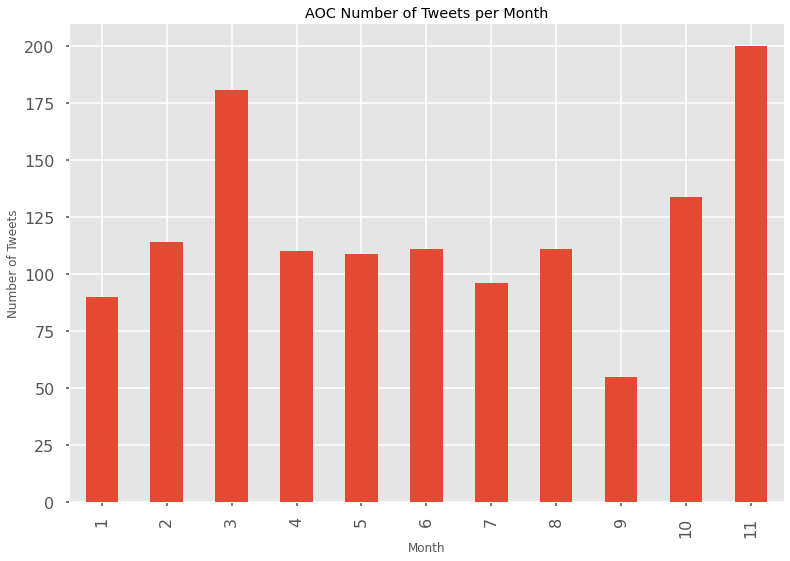

<Figure size 504x504 with 0 Axes>

In [24]:
aoc_df.groupby('Month')['Tweet Id'].count().plot.bar()
plt.ylabel('Number of Tweets')
plt.title("AOC Number of Tweets per Month")
plt.figure(figsize=[7,7]);

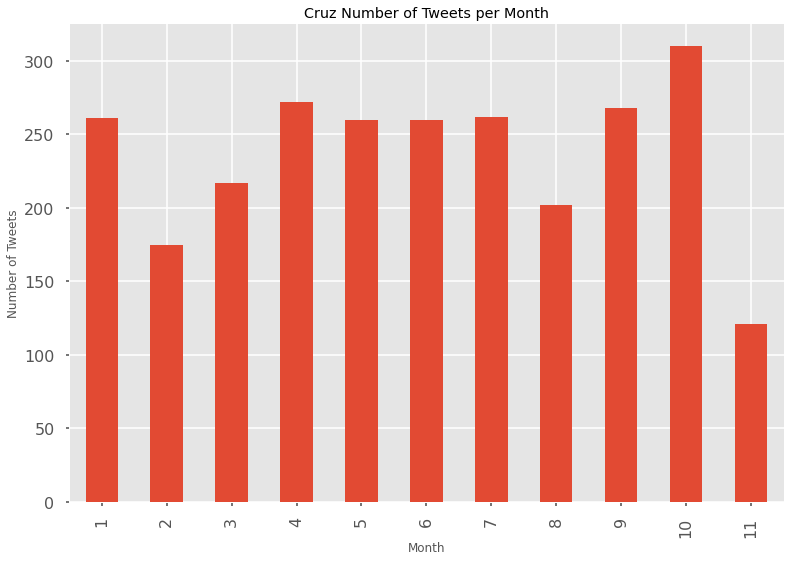

In [25]:
cruz_df.groupby('Month')['Tweet Id'].count().plot.bar()
plt.ylabel('Number of Tweets')
plt.title("Cruz Number of Tweets per Month");

In [13]:
from nltk import wordpunct_tokenize, word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from collections import Counter

In [14]:
sw = stopwords.words('english')
wn = WordNetLemmatizer()
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

In [15]:
def clean_tweets(x):
    x = x.lower()
    tokens = tknzr.tokenize(x)
    tokens = [tok for tok in tokens if tok.isalnum()]
    tokens = [tok for tok in tokens if tok not in sw]
    tokens = [wn.lemmatize(tok) for tok in tokens]
    return(" ".join(tokens))

In [16]:
aoc_text_clean = aoc_df['Text'].apply(clean_tweets)
cruz_text_clean = cruz_df['Text'].apply(clean_tweets)

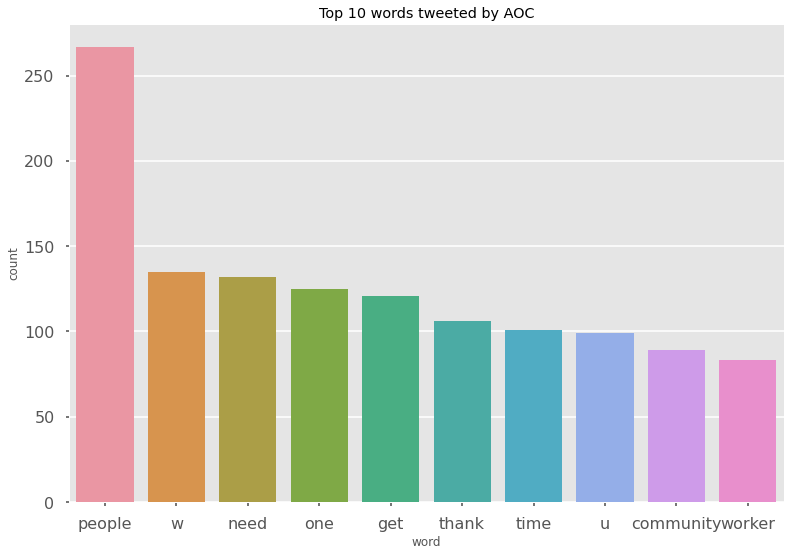

<Figure size 504x504 with 0 Axes>

In [26]:
aoc_top_words = pd.DataFrame(Counter(" ".join(aoc_text_clean).split()).most_common(10))
aoc_top_words.columns = ['word', 'count']

sns.barplot(data=aoc_top_words, x='word', y='count')
plt.title('Top 10 words tweeted by AOC')
plt.figure(figsize=[7,7]);

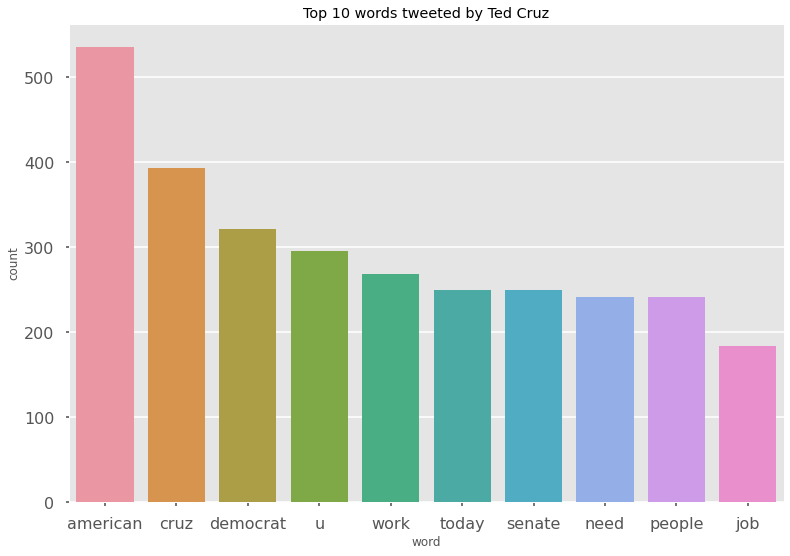

<Figure size 504x504 with 0 Axes>

In [27]:
cruz_top_words = pd.DataFrame(Counter(" ".join(cruz_text_clean).split()).most_common(10))
cruz_top_words.columns = ['word', 'count']

sns.barplot(data=cruz_top_words, x='word', y='count')
plt.title('Top 10 words tweeted by Ted Cruz')
plt.figure(figsize=[7,7]);

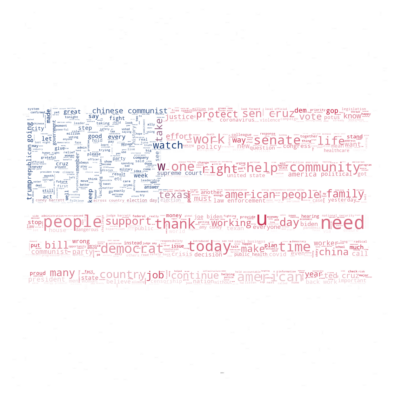

In [30]:
#This visual is useless for providing information for our EDA but it is a fun visual!
#Uncomment the command below if wordcloud is not installed
# !pip install wordcloud
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

all_tweets = pd.concat([aoc_text_clean, cruz_text_clean])
# Counter(' '.join(all_tweets).split()).most_common(10)

#Some rows have empty strings so I must remove them
all_tweets.replace('', np.nan, inplace=True)
all_tweets.dropna(inplace=True)

mask = np.array(Image.open("C:/Users/cherndon/python_practice/Final Project/us flag.jpg"))

wordcloud = WordCloud(background_color="white", max_words=1000, mode="RGBA", mask=mask).generate(' '.join(all_tweets))
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')
plt.show()

---
The sections below don't really help with EDA or with our predictions. I wanted to run a KMeans clustering on the tweets to see if any interesting grouping would occur in the tweets. Below are the results of the KMeans clustering algorithm 

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
tf = TfidfVectorizer(max_df=.995, min_df=.005)

In [32]:
X = tf.fit_transform(all_tweets)

In [33]:
wcss_tweets = []
for k in range(3, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    wcss_tweets.append(kmeans.inertia_)

Text(0, 0.5, 'WCSS')

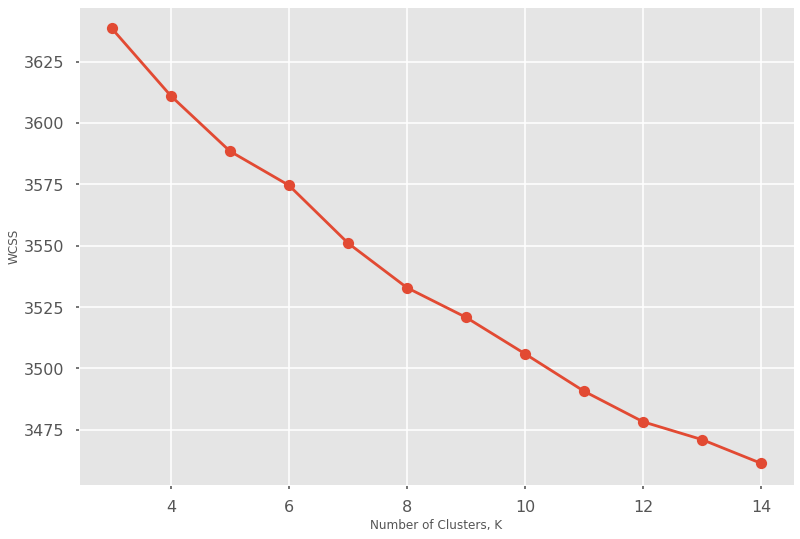

In [34]:
plt.plot(np.arange(3,15), wcss_tweets, marker="o")
plt.xlabel('Number of Clusters, K')
plt.ylabel('WCSS');

In [35]:
from sklearn.cluster import MiniBatchKMeans

In [36]:
k = 8
kmeans = MiniBatchKMeans(k)
kmeans.fit(X)
labs = kmeans.predict(X)

Again this part doesnt provide information that helps us in our prediction process. I wanted to run a clustering method just out of my own curiosity and because the results always surprise me

In [37]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tf.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: cruz ted sen one people community today say time would
Cluster 1: court election supreme day barrett senate vote democrat constitutional confirm
Cluster 2: make trump service military death mistake administration look life black
Cluster 3: thank honor today relief work leadership life deeply religious moment
Cluster 4: energy woman historic america mission result tax get climate real
Cluster 5: right need democrat violence leader law country police community american
Cluster 6: chinese party communist china global sanction ccp threat government hong
Cluster 7: american job work back get people economy help china bill


---
### **Methods & Results**

To answer the prediction question, I decided to use a Multinomial Naive Bayes model. I chose this model because it is realtively simple to use yet still provides powerful results.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score

In [39]:
combined_df = pd.concat([aoc_df, cruz_df])
combined_df.drop(columns=['Datetime', 'Tweet Id', 'Month'], inplace=True)
combined_df['Text'] = combined_df['Text'].apply(clean_tweets)
#Some rows have empty strings so I must remove them
combined_df['Text'].replace('', np.nan, inplace=True)
combined_df.dropna(inplace=True)

In [40]:
combined_df.head()

,Text,Username
0,grateful joined u last night wonderful learnin...,AOC
1,200k raised one livestream whim eviction defen...,AOC
3,dm need contact info,AOC
4,hasan say reach,AOC
5,today using stream fundraise local food pantry...,AOC


In [41]:
value_sums = combined_df['Username'].value_counts().sum()
combined_df['Username'].value_counts() / value_sums

SenTedCruz    0.67524
AOC           0.32476
Name: Username, dtype: float64

In [42]:
train, test = train_test_split(combined_df, test_size=0.3, stratify=combined_df.Username, random_state=777)

In [43]:
y_train = (train['Username'] == 'AOC').astype(int)
y_test = (test['Username'] == 'AOC').astype(int)

In [44]:
tfidf = TfidfVectorizer(max_df = .995, min_df = .005)
tfidf.fit(train['Text'])
X_train = tfidf.transform(train['Text'])
X_test = tfidf.transform(test['Text'])

In [45]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
yhat = nb.predict(X_test)

confusion_matrix(y_test, yhat)

array([[749,  31],
       [140, 235]], dtype=int64)

In [56]:
print("The accuracy score of the Multinomial Navie Bayes model is {:.2f}".format(accuracy_score(y_test, yhat)))
print("The f1 score of the Multinomial Navie Bayes model is {:.2f}".format(f1_score(y_test, yhat)))
print("The precision score of the Multinomial Navie Bayes model is {:.2f}".format(precision_score(y_test, yhat)))
print("The recall score of the Multinomial Navie Bayes model is {:.2f}".format(recall_score(y_test, yhat)))

The accuracy score of the Multinomial Navie Bayes model is 0.85
The f1 score of the Multinomial Navie Bayes model is 0.73
The precision score of the Multinomial Navie Bayes model is 0.88
The recall score of the Multinomial Navie Bayes model is 0.63


In [47]:
probabilities = nb.predict_proba(X_test)
y_prob = nb.predict_proba(X_test)[:,1]

In [48]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

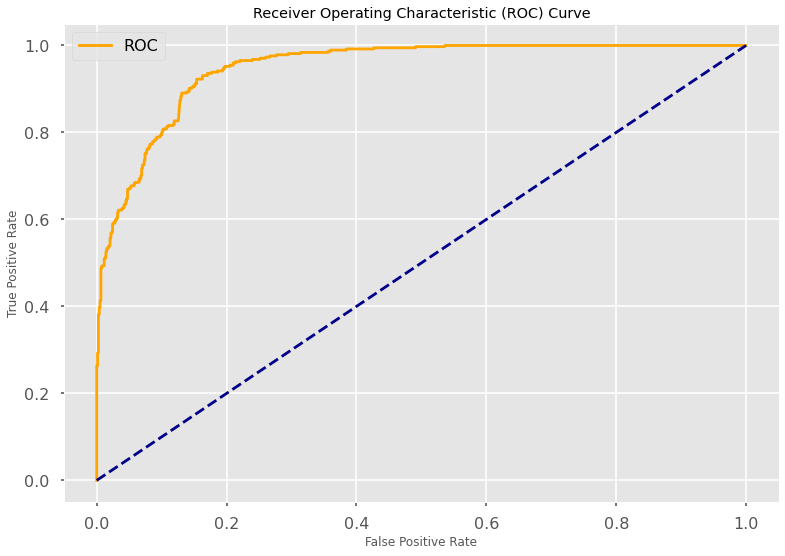

In [49]:
fpr, tpr, thresh = roc_curve(y_test, y_prob)
plot_roc_curve(fpr, tpr)

In [50]:
roc_auc_score(y_test, y_prob)

0.948557264957265

In [51]:
feats = pd.DataFrame()
feats['words'] = tfidf.get_feature_names()
# Convert log probabilities to probabilities. 
feats['AOC'] = np.e**(nb.feature_log_prob_[0, :])
feats['SenTedCruz'] = np.e**(nb.feature_log_prob_[1, :])
feats.set_index('words', inplace=True)

In [52]:
feats.sort_values(by='AOC',ascending=False).head(15)

,AOC,SenTedCruz
words,,
cruz,0.012731,0.000465
american,0.010878,0.001527
democrat,0.008356,0.000668
senate,0.006681,0.001912
sen,0.006515,0.000931
work,0.006175,0.005048
today,0.005897,0.003043
need,0.005111,0.007488
people,0.004857,0.011983
